In [2]:
from matplotlib import pyplot as plt
import json
import numpy as np
import pandas as pd
from collections import OrderedDict

pcolors = OrderedDict([('blue', [0.00, 0.33, 0.66]),
                       ('green', [0.33, 0.66, 0.00]),
                       ('red', [0.66, 0.00, 0.00]),
                       ('cyan', [0.00, 0.66, 0.66]),
                       ('purple', [0.33, 0.00, 0.66]),
                       ('orange', [0.75, 0.50, 0.00])])

plt.rcParams['figure.figsize'] = (3.3, 2)
plt.rcParams['figure.dpi'] = 240
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'w'
plt.rcParams['savefig.facecolor'] = 'w'
plt.rcParams['savefig.dpi'] = 600

%matplotlib inline

rc = %config InlineBackend.rc
rc['savefig.dpi'] = 150

In [3]:
particles = 1000
rho = 0.1
kappa = 0.5
gamma = 0.9
depth_range = np.arange(0,12,2)+1
train_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

results_dir = '../results/guess-who/'

In [5]:
# load baselines
baseline_types = ['uniform', 'myopic-voi']
baseline_path = '%s/guess-who-%s-depth%d.json'

baselines = {}
for p in baseline_types:
    baselines[p] = {}
    for d in depth_range:
        try:
            baselines[p][d] = json.load(open(baseline_path % (results_dir, p, d), 'r'))
        except:
            pass

In [6]:
# load trials
trial_types = ['discounted-belief']
trial_path = '%s/guess-who-%s-depth%d-particles%d-rho%0.1f-gamma%0.1f-kappa%0.1f-steps%05d.json' 

trials = {}
for p in trial_types:
    trials[p] = {}
    for d in depth_range:
        trials[p][d] = {}
        for n in train_range:
            try:
                trials[p][d][n] = json.load(open(trial_path % (results_dir, p, d, particles, rho, gamma, kappa, n), 'r'))
                # print trial_path % (results_dir, p, d, particles, rho, gamma, kappa, n)
                print'.',
            except:
                pass        

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [7]:
# plot mean rewards as a function of training steps
trial_rewards = pd.DataFrame(dict(((p,d,n), np.array(trials[p][d][n]['rewards']) \
                                      / (24 * trials[p][d][n]['number-of-test-sweeps']))
                                  for p in trials for d in trials[p] for n in trials[p][d]))

baseline_rewards = pd.DataFrame(dict(((p,d), np.array(baselines[p][d]['rewards']) \
                                      / (24 * baselines[p][d]['number-of-test-sweeps']))
                                     for p in baselines for d in baselines[p]))

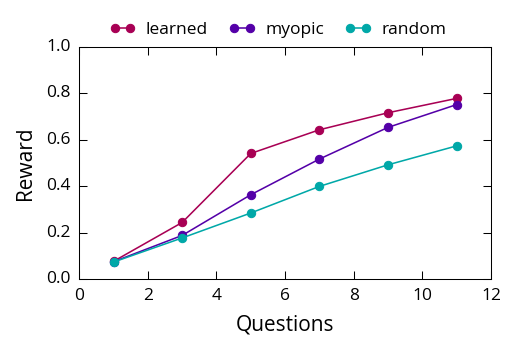

In [10]:
colors = {'linear-belief': [0.00, 0.33, 0.66],
          'discounted-belief': [0.66, 0.00, 0.33],
          'logistic-info': [0.75, 0.25, 0.00],
          'uniform': [0.00, 0.66, 0.66],
          'myopic-voi': [0.33, 0.00, 0.66]}

labels = {'discounted-belief': 'learned',
          'myopic-voi': 'myopic', 
          'uniform': 'random'}

fig = plt.figure(figsize=(3.25,2.0))
ax = fig.gca()
for p in trials:
    mean_reward = trial_rewards[p].mean().groupby(level=0).max()
    ax.plot(mean_reward.index,
            mean_reward.values,
            '-o', mec=colors[p],
            color = colors[p],
            label = labels[p])

for p in baselines:
    mean_reward = baseline_rewards[p].mean()
    ax.plot(mean_reward.index,
            mean_reward.values,
            '-o', mec=colors[p],
            color = colors[p],
            label = labels[p])

ax.set_xlabel('Questions')
ax.set_ylabel('Reward')
ax.set_ylim([0, 1.0])
lgd = ax.legend(bbox_to_anchor=(0.13, 1.075, 0.8, .10), ncol=3,
                handlelength=1.5, handletextpad=0.6, columnspacing=1.2)

fig.tight_layout(pad=0.05)
for ext in ['png','pdf','svg']:
    fig.savefig('../plots/guess-who/guess_who_reward_vs_questions.%s' % ext,
                bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)

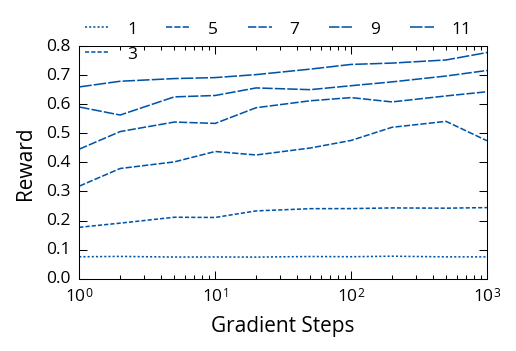

In [11]:
colors = {}
for d in depth_range:
    colors[d] = plt.cm.hsv(1.2 * d / 1.2 * depth_range[-1])
    
for p in trials:
    fig = plt.figure(figsize=(3.25,2))
    ax = fig.gca()
    for w,d in enumerate(depth_range):
        mean_reward = trial_rewards[p][d].mean()
        std_reward = trial_rewards[p][d].std()
        l, = ax.semilogx(mean_reward.index,
                    mean_reward.values,
                    linestyle = 'dotted',
                    color = pcolors['blue'], mec = pcolors['blue'],
                    label = '%d' % d)
        l.set_dashes([w+1,1.0])
        
ax.set_xlabel('Gradient Steps')
ax.set_ylabel('Reward')
ax.set_ylim([0, 0.8])
ax.set_xlim([0, 1000])
lgd =ax.legend(bbox_to_anchor=(0.2, 1.075, 0.8, .10), ncol=5, 
               handlelength=2.0, handletextpad=0.7, columnspacing=1.4)

fig.tight_layout(pad=0.05)
for ext in ['png','pdf','svg']:
    fig.savefig('../plots/guess-who/guess_who_reward_vs_steps.%s' % ext,
                bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)